# 1. importation des librairies et preparation des données

## 1.1 importation des librairies

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

## 1.2 importation des dataframes

In [31]:
aide = pd.read_csv('./sources/aide_alimentaire.csv')
dispo = pd.read_csv('./sources/dispo_alimentaire.csv')
pop = pd.read_csv('./sources/population.csv')
lack = pd.read_csv('./sources/sous_nutrition.csv')
fao_stat =  pd.read_csv('./sources/FAOSTAT.csv')

## 1.3 preparation des dataframes

In [32]:
# preparation du fichier fao_stat

fao_stat= fao_stat.drop(['Domaine', 'Code Domaine','Code zone (M49)', 'Code Élément','Élément','Code Produit', 'Code année', 'Note' ,'Symbole','Produit'], axis=1)
fao_stat.isna()
fao_stat= fao_stat.dropna(axis=0)
fao_stat['Valeur'] = fao_stat['Valeur'].astype(float)
fao_stat = fao_stat[fao_stat['Année']=='2016-2018']
fao_stat.head()

,Zone,Année,Unité,Valeur,Description du Symbole
13,Australie,2016-2018,%,2.5,Valeur estimée
18,Autriche,2016-2018,%,2.5,Valeur estimée
23,Azerbaïdjan,2016-2018,%,2.5,Valeur estimée
38,Bélarus,2016-2018,%,2.5,Valeur estimée
43,Belgique,2016-2018,%,2.5,Valeur estimée


In [33]:
# preparation du fichier population

pop.drop(pop.loc[pop['Année']!=2017].index, inplace=True)
pop.rename(columns={'Valeur':'Population'},inplace=True )
pop.head()

,Zone,Année,Population
4,Afghanistan,2017,36296.113
10,Afrique du Sud,2017,57009.756
16,Albanie,2017,2884.169
22,Algérie,2017,41389.189
28,Allemagne,2017,82658.409


In [34]:
# preparation du fichier sous nutrition

new_lack = lack.copy()
new_lack = new_lack[new_lack['Année']=='2016-2018']


In [35]:
# fusion des fichiers fao_stats et population, conversion du nombre d'habitants "Valeur" en nombre reel, exprimé en millions

new = pd.merge(fao_stat, pop, on=["Zone"], how='left')
#display(new)
new["Valeur1"]= ((new.Valeur * new.Population / 100) * 0.001)
new["Valeur1"] = new["Valeur1"].round(decimals=1)
new = new.drop( ["Année_x", "Unité"], axis=1)
new.head()

,Zone,Valeur,Description du Symbole,Année_y,Population,Valeur1
0,Australie,2.5,Valeur estimée,2017,24584.620,0.6
1,Autriche,2.5,Valeur estimée,2017,8819.901,0.2
2,Azerbaïdjan,2.5,Valeur estimée,2017,9845.320,0.2
3,Bélarus,2.5,Valeur estimée,2017,9450.231,0.2
4,Belgique,2.5,Valeur estimée,2017,11419.748,0.3


In [36]:
# Fusion entre le fichier des données de sous nutrition, et du nouveau fichier possedant les valeurs manquantes

sous_nutrition_2 = pd.merge(new_lack, new, on='Zone', how="left")

sous_nutrition_2['Valeur_x'].fillna(sous_nutrition_2['Valeur1'],inplace=True)
#display(sous_nutrition_2[:15])
sous_nutrition_2 = sous_nutrition_2.drop(['Année_y', "Valeur1", 'Valeur_y'], axis=1)
sous_nutrition_2.head()


,Zone,Année,Valeur_x,Description du Symbole,Population
0,Afghanistan,2016-2018,10.5,NaN,NaN
1,Afrique du Sud,2016-2018,3.1,NaN,NaN
2,Albanie,2016-2018,0.1,NaN,NaN
3,Algérie,2016-2018,1.3,NaN,NaN
4,Allemagne,2016-2018,NaN,NaN,NaN


In [37]:
# Fusion entre le fichier de sous nutrition et le fichier de population
sous_nutrition_2 = pd.merge(sous_nutrition_2, pop, on='Zone', how='left')
sous_nutrition_2 = sous_nutrition_2.dropna(axis=0, thresh=5)
sous_nutrition_2.drop(["Population_x","Année_y"],axis=1, inplace=True)
sous_nutrition_2['Valeur_x'] = sous_nutrition_2['Valeur_x'].replace("<0.1","0.1")
sous_nutrition_2['Valeur_x'] = sous_nutrition_2['Valeur_x'].astype(float)
sous_nutrition_2.head()

,Zone,Année_x,Valeur_x,Description du Symbole,Population_y
0,Afghanistan,2016-2018,10.5,NaN,36296.113
1,Afrique du Sud,2016-2018,3.1,NaN,57009.756
2,Albanie,2016-2018,0.1,NaN,2884.169
3,Algérie,2016-2018,1.3,NaN,41389.189
6,Angola,2016-2018,5.8,NaN,29816.766


# 2. Annalyse generale

## 2.1 proportion de personnes en état de sous-nutrition 

In [38]:

pop_monde = sous_nutrition_2['Population_y'].sum() # Calcule du nombre d'habitant dans le monde
sous_nut_monde = sous_nutrition_2['Valeur_x'].sum() # Calcule du nombre de personne en etat de sous nutrition
prop_sous_nut_monde = round((sous_nut_monde/pop_monde) * 100000, 1) 
print(prop_sous_nut_monde)
sous_nutrition_2.head()


9.1


,Zone,Année_x,Valeur_x,Description du Symbole,Population_y
0,Afghanistan,2016-2018,10.5,NaN,36296.113
1,Afrique du Sud,2016-2018,3.1,NaN,57009.756
2,Albanie,2016-2018,0.1,NaN,2884.169
3,Algérie,2016-2018,1.3,NaN,41389.189
6,Angola,2016-2018,5.8,NaN,29816.766


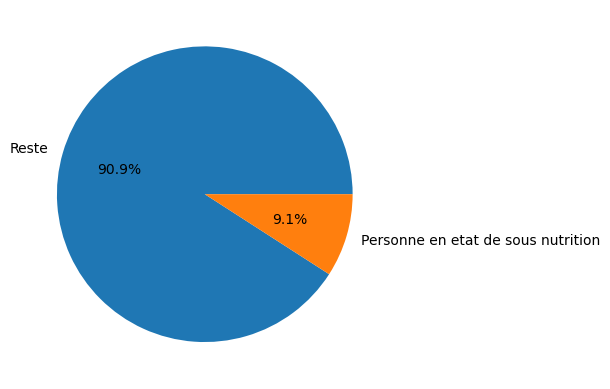

In [39]:
#Representation de la proportion de la sous nutrition dans le monde 
reste = 100 - prop_sous_nut_monde
data = [reste, prop_sous_nut_monde]
labels=["Reste", "Personne en etat de sous nutrition"]
plt.pie(data, labels=labels ,autopct='%0.1f%%')
plt.show()

## 2.2 nombre théorique de personnes qui pourraient être nourries

In [40]:

#Preparation du fichier de disponibilite alimentaire 

new_dispo = pd.read_csv('./sources/dispo_alimentaire.csv')

new_dispo = new_dispo.groupby('Zone').sum(['Disponibilité alimentaire (Kcal/personne/jour)']) #calcul du nbr de kcal disponible par pays 
new_dispo = pd.merge(new_dispo, pop, on=['Zone'], how="left")
new_dispo.drop(new_dispo.loc[new_dispo['Année']!=2017.0].index, inplace=True)




In [41]:
new_dispo["Kcal/pays/jour"]= (new_dispo['Disponibilité alimentaire (Kcal/personne/jour)'] * new_dispo["Population"])
Kcal_monde = new_dispo["Kcal/pays/jour"].sum()
pop_monde = new_dispo['Population'].sum()
fed_humans = (Kcal_monde / 2500)
print(round(fed_humans), "personnes pourraient theoriquement etre nourris")
fed_humans = (fed_humans / pop_monde )* 100

print("ce qui represente",round(fed_humans),"% de la population mondiale")

8367594 personnes pourraient theoriquement etre nourris
ce qui represente 115 % de la population mondiale


## 2.3 nombre théorique de personnes qui pourraient être nourries a partir de la disponibilité alimentaire des produits végétaux 

In [42]:
vegetal = pd.read_csv('./sources/dispo_alimentaire.csv')

vegetal = vegetal.loc[vegetal['Origine']== 'vegetale']
vegetal = vegetal.groupby('Zone').sum(['Disponibilité alimentaire (Kcal/personne/jour)'])
vegetal = pd.merge(vegetal, pop, on=['Zone'], how="left")
vegetal.drop(vegetal.loc[vegetal['Année']!=2017.0].index, inplace=True)

vegetal.head()

,Zone,Aliments pour animaux,Autres Utilisations,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Semences,Traitement,Variation de stock,Année,Population
0,Afghanistan,645.0,415.0,1871.0,271.49,18.27,46.05,10884.0,278.0,2638.0,8293.0,1072.0,8891.0,393.0,63.0,-368.0,2017.0,36296.113
1,Afrique du Sud,5122.0,761.0,2533.0,425.17,48.92,48.94,53439.0,10586.0,6468.0,22441.0,2110.0,55649.0,186.0,22819.0,1912.0,2017.0,57009.756
2,Albanie,559.0,172.0,2203.0,706.49,38.76,51.96,3326.0,84.0,846.0,2241.0,182.0,2609.0,55.0,113.0,-45.0,2017.0,2884.169
3,Algérie,4352.0,1706.0,2915.0,632.35,54.12,66.94,35510.0,649.0,14672.0,24797.0,3587.0,21964.0,428.0,637.0,-479.0,2017.0,41389.189
4,Allemagne,28122.0,6842.0,2461.0,568.82,63.63,39.90,126866.0,34454.0,50642.0,47079.0,3717.0,110926.0,1475.0,39686.0,-247.0,2017.0,82658.409


In [43]:
vegetal["Kcal/pays/jour"]= (vegetal['Disponibilité alimentaire (Kcal/personne/jour)']* vegetal["Population"])
calorie_jour = vegetal["Kcal/pays/jour"].sum()
personne_nourris = calorie_jour / 2500
prop_personne_nourris = round((personne_nourris/ pop_monde) *100)

print("On pourrait theoriquement nourrir",prop_personne_nourris,"% de la population mondiale juste avec la disponibilitee en vegetaux.")

On pourrait theoriquement nourrir 95 % de la population mondiale juste avec la disponibilitee en vegetaux.


## 2.3 utilisation de la disponibilité intérieure

In [44]:
dispo_sum = dispo['Disponibilité intérieure'].sum()
animaux = dispo['Aliments pour animaux'].sum()
animaux = animaux * 100 / dispo_sum
pertes = dispo['Pertes'].sum()
pertes = pertes * 100 / dispo_sum
humains = dispo['Nourriture'].sum()
humains = humains * 100 / dispo_sum

print("La part de cereales pour les animaux est de", round(animaux,1), "%.")
print("La part de cereales pour les humains est de", round(humains, 1), "%." )
print(round(pertes,1),"% des cereales sont perdus.")


La part de cereales pour les animaux est de 13.2 %.
La part de cereales pour les humains est de 49.5 %.
4.6 % des cereales sont perdus.


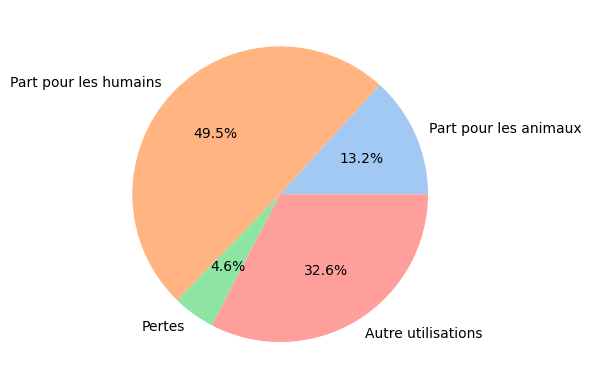

In [45]:
data = [animaux, humains, pertes, 100 -(animaux+ humains+ pertes)]
colors = sns.color_palette('pastel')
labels = ['Part pour les animaux', 'Part pour les humains', 'Pertes', 'Autre utilisations']
plt.pie(data, colors = colors, labels=labels,  autopct = '%0.1f%%')
plt.show()


# 3. Questions specifiques

## 3.1  lien logique entre l’ensemble des 10 variables de l'utilisation de la disponibilité intérieure

disponibilité interieure = 
importation + production - exportations + variation de stock = 
nourriture + pertes + semences + aliments pour animaux + autre utilisations + traitement

## 3.2 utilisation des céréales

In [46]:
#On determine la liste des cereales
cereal = ['Avoine','Blé','Céréales, Autres','Maïs','Miel','Millet',
'Orge','Riz (Eq Blanchi)','Seigle','Sorgho', "Alpiste","Triticale","Céréales élangées",
"Fonio","Quinoa","Riz, paddy","Sarrasin, blé noir"]

dispo_cereal = dispo[dispo['Produit'].isin(cereal)] # On ne garde que le lignes qui correspondent aux cereales

animals = dispo_cereal['Aliments pour animaux'].sum()
nut = dispo_cereal['Nourriture'].sum()
disp = dispo_cereal['Disponibilité intérieure'].sum()
nut = (nut / disp) * 100
animals = (animals / disp) * 100

print(round(nut,1), "% des cereales sont utilisees pour la nourriture\n" , round(animals,1),
"% des cereales sont utilisees pour la nourriture animal")



42.8 % des cereales sont utilisees pour la nourriture
 36.3 % des cereales sont utilisees pour la nourriture animal


## 3.3 utilisation du manioc par la Thaïlande

In [47]:
dispo_thai = dispo[dispo['Zone']=='Thaïlande']
dispo_thai = dispo_thai[dispo_thai['Produit']=='Manioc']
display(dispo_thai)
export = dispo_thai['Exportations - Quantité'].sum()
prod = dispo_thai['Production'].sum()
print(export, prod)

# exportation de plus de la moitie de produciton de manioc en thailande, avec un nombre de personnes en sous nutrition supérieur a 6 millions

,Zone,Produit,Origine,Aliments pour animaux,Autres Utilisations,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Semences,Traitement,Variation de stock
13809,Thaïlande,Manioc,vegetale,1800.0,2081.0,40.0,13.0,0.05,0.14,6264.0,25214.0,1250.0,871.0,1511.0,30228.0,NaN,0.0,0.0


25214.0 30228.0


In [48]:
dispo_manioc = dispo
dispo_manioc.head()
importation = dispo_manioc["Importations - Quantité"].sum()
propo =( export / importation) * 1000

print("La Thailande produit a elle seule ",round(propo,1),"% du manioc importe dans le monde")

La Thailande produit a elle seule  19.5 % du manioc importe dans le monde


# 4. annalyse approfondie

## 4.1 pays dont la proportion de personnes sous-alimentées est la plus elevée en 2017

In [49]:
sortd = sous_nutrition_2

sortd['prop'] = (sortd['Valeur_x'] / (sortd['Population_y'] / 1000)) * 100
sortd = sortd.sort_values(by = 'prop', ascending = False)
sortd.drop(sortd.loc[sortd['Valeur_x']==0.1].index, inplace=True)

display(sortd[:10])


,Zone,Année_x,Valeur_x,Description du Symbole,Population_y,prop
78,Haïti,2016-2018,5.3,NaN,10982.366,48.259182
157,République populaire démocratique de Corée,2016-2018,12.0,NaN,25429.825,47.188685
200,Yémen,2016-2018,13.0,Valeur estimée,27834.819,46.704094
151,République centrafricaine,2016-2018,2.1,Valeur estimée,4596.023,45.691677
108,Madagascar,2016-2018,10.5,NaN,25570.512,41.062924
103,Libéria,2016-2018,1.8,NaN,4702.226,38.279742
100,Lesotho,2016-2018,0.8,NaN,2091.534,38.249438
183,Tchad,2016-2018,5.7,NaN,15016.753,37.957606
154,République démocratique du Congo,2016-2018,29.6,Valeur estimée,81398.764,36.364189
161,Rwanda,2016-2018,4.2,NaN,11980.961,35.055619


## 4.2 pays ayant le plus bénéficié d’aide depuis 2013

In [50]:
aide =aide.groupby("Pays bénéficiaire").sum(["Valeur"])
aide.drop(["Année"], axis=1, inplace=True)
aide =aide.sort_values(by = 'Valeur', ascending = False)
aide.head(10)

,Valeur
Pays bénéficiaire,
République arabe syrienne,1858943
Éthiopie,1381294
Yémen,1206484
Soudan du Sud,695248
Soudan,669784
Kenya,552836
Bangladesh,348188
Somalie,292678
République démocratique du Congo,288502


## 4.3 pays ayant le plus de disponibilité/habitant

In [51]:
dispo = dispo.groupby("Zone").sum(['Disponibilité alimentaire (Kcal/personne/jour)'])
dispo = dispo.sort_values(by = 'Disponibilité alimentaire (Kcal/personne/jour)', ascending = False)
display(dispo["Disponibilité alimentaire (Kcal/personne/jour)"][:10])

Zone
Autriche                 3770.0
Belgique                 3737.0
Turquie                  3708.0
États-Unis d'Amérique    3682.0
Israël                   3610.0
Irlande                  3602.0
Italie                   3578.0
Luxembourg               3540.0
Égypte                   3518.0
Allemagne                3503.0
Name: Disponibilité alimentaire (Kcal/personne/jour), dtype: float64

## 4.3 pays ayant le moins de disponibilité/habitant

In [52]:
dispo = dispo.sort_values(by = 'Disponibilité alimentaire (Kcal/personne/jour)', ascending = True)
display(dispo["Disponibilité alimentaire (Kcal/personne/jour)"][:10])

Zone
République centrafricaine                     1879.0
Zambie                                        1924.0
Madagascar                                    2056.0
Afghanistan                                   2087.0
Haïti                                         2089.0
République populaire démocratique de Corée    2093.0
Tchad                                         2109.0
Zimbabwe                                      2113.0
Ouganda                                       2126.0
Éthiopie                                      2129.0
Name: Disponibilité alimentaire (Kcal/personne/jour), dtype: float64

# 5. conclusion

- 9,1 % de la population mondiale souffre de sous nutrition.

- Si la totalite de la production alimentaire etait utilisee pour la nourriture humaine, on pourrait nourrir 115% de la population mondiale.
Ce chiffre descend a 95% si on ne compte que les vegetaux.

- La thailande exporte la majorite de son manioc : 83%.
Et est le premier exportateur mondial. Le manioc Thailandais represente 19% des importations de manioc dans le monde. 

- On se rend compte que sur la liste des 10 pays dont la proportion de sous nutrition est la plus elevee, 
seul le Yemen et la Republique democratique du Congo sont egalement dans la liste des pays ayant le plus beneficiee de l'aide alimentaire.